# Slightly Off the Beaten Path - Starter Notebook

The Sandbox version of the larger [Off the Beaten Path Challenge](https://xeek.ai/challenges/off-the-beaten-path).

# Problem Statement
"Off the Beaten Path" Challenge is a more complex variation of a [traveling salesman](https://en.wikipedia.org/wiki/Travelling_salesman_problem) problem.  The problem presented here introduces additional constraints and degrees of freedom (variables).  The whole challenge aims to find the most optimal plan for exploration and reward extraction.  The solution to the challenge is not only the plan but also an algorithm that will be tested on holdout problem spaces; therefore, you have to keep in mind that you are developing a universal tool for finding a solution.  The problem can be summarized in the below points:

### Goal
1.  Goal of the challenge is to develop an algorithm that extracts as many rewards as possible in a given time, Budget, and graph.
2.  Rewards are extracted from points on the graph called Sites.
3.  Workers extract rewards.

### Graph/Map
1.  Graph, or map, is a set of connected points on the coordinate plane, which are called Verticies.
2.  There are different types of Verticies:
    * Origin - a starting point for every worker
    * Basic - regular point in the graph
    * Site - a point with a reward that can be extracted
3.  Graph also contains Edges, which connect different Verticies.

### Movement
1.  A movement can happen only between connected Verticies.
2.  In one timestep, a worker can move along one edge.

### Rewards extraction
1.  Rewards are extracted from Sites.
2.  There are different types of Sites, each worth different levels of Rewards.
3.  Specified types of workers can access each type of Site.  The extraction lasts for a specified number of time steps.  The greater the Reward, the greater number of extraction time steps.
4.  If the extraction cannot be finished in a given amount of time specified by the constraint, it cannot be started.
5.  The Reward from one Site can only be extracted once.  After it's extracted, it no longer produces a reward.

### Workers
1.  Workers have their cost per timestep, which depletes the Budget.
2.  One can employ as many Workers for as many timesteps as the Budget allows.
3.  Different Worker types have different costs.
4.  Different Worker types can access different Sites:
  * Worker 1 Type can access Type 1 sites.
  * Worker 2 Type can access Type 1 and 2 Sites.
  * Worker 3 Type can access Types 1, 2, and 3 Sites.
6.  Each worker has to start their journey from the Origin vertex.


The following notebook is a starting point for you on this challenge, demonstrating how to work with the problem space, create a submission, and an example solution for you to build on.

## Contents
1. Quickstart with prepared configuration
2. Inspect the graph
3. Sample solution
4. Sample Submission
5. Parameters for Test Graph
6. Common errors and mistakes
6. APPENDIX: Work with `Graph` object
7. APPENDIX: Work with `Configuration` object

In [ ]:
import random
from copy import deepcopy
from random import randint

import lyra_graphtool as lgtool
from lyra_graphtool import Configuration, Config_Single_Time, Edge, Graph, Graph_Type, Parameters, Vertex, Worker_Type, Vertex_Type

## 1. Quickstart with prepared configuration

Below we present way to load the graph and constraints prepared by us and start working on a problem.

First of all you need to use `ProcessArgs.load()` method with argument and graph files.

In [ ]:
pargs = lgtool.ProcessArgs.load(arguments_file='args_sandbox', graph_file='Test_Graph_Slightly_Off_the_Beaten_Path.json')

Next, loaded arguments and graph can be wrapped with `Parameters` class which can be further passed to configuration file.

In [ ]:
params = lgtool.Parameters(pargs.graph,
                           budget = pargs.args_trial.budget,
                           duration_time = pargs.args_trial.duration,
                           cost_rate = pargs.worker_cost_rate
                           )

cfg = lgtool.Configuration(params)

And that's it! `Configuration` object is the one storing your schedule and the main object you will work with. For more details on how to work with it read further chapters.

## 2. Inspect the Graph

The `lyra_graphtool.Configuration` object contains a graph to be optimized and problem constraints and setup such as budget, duration, and worker's cost rates.  The Configuration object contains `lyra_graphtool.Graph`, an object with useful methods that will be described later in this notebook.

Let's view the loaded graph using the print_graph() method as well as budget and time constraints.  The graph, budget, and time pertain to the Sandbox version only.

Problem budget constraint: 10000.0
Problem duration constraint: 20
Worker cost rates per timestep: {<Worker_Type.WORKER1: 0>: 100.0, <Worker_Type.WORKER2: 1>: 200.0, <Worker_Type.WORKER3: 2>: 500.0}


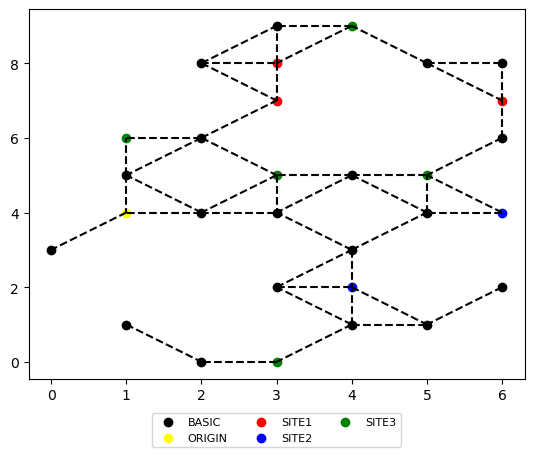

In [ ]:
print(f"Problem budget constraint: {cfg.budget}")
print(f"Problem duration constraint: {cfg.duration_time}")
print(f"Worker cost rates per timestep: {cfg.worker_cost_rate}")
cfg.graph.print_graph()

The 'Configuration' object contains a dictionary under the `config` attribute. Here's its structure.
```python
{
    worker_type_1:
        {
            worker_1:
                {
                    timestep_1: Config_Single_Time,
                    timestep_2: Config_Single_Time,
                    ...
                    timestep_n: Config_Single_Time,
                },
            worker_2:
                {
                    timestep_1: Config_Single_Time,
                    timestep_2: Config_Single_Time,
                    ...
                    timestep_n: Config_Single_Time,
                }
            ...
            worker_n:
                {
                    timestep_1: Config_Single_Time,
                    timestep_2: Config_Single_Time,
                    ...
                    timestep_n: Config_Single_Time,
                }
        }
    ...
    worker_type_n:
        {
            worker_1:
                {
                    timestep_1: Config_Single_Time,
                    timestep_2: Config_Single_Time,
                    ...
                    timestep_n: Config_Single_Time,
                },
            worker_2:
                {
                    timestep_1: Config_Single_Time,
                    timestep_2: Config_Single_Time,
                    ...
                    timestep_n: Config_Single_Time,
                }
            ...
            worker_n:
                {
                    timestep_1: Config_Single_Time,
                    timestep_2: Config_Single_Time,
                    ...
                    timestep_n: Config_Single_Time,
                }
        }
}
```

The goal of this challenge is to fill this dictionary with the most optimal strategy for extracting rewards within budget and time.  Each timestep has a `Config_Single_Time` object at the beginning.  For example:

In [ ]:
# The indexes are cfg.config[worker_type][worker_number][timestep]
print(cfg.config[Worker_Type.WORKER1][0][0])
cfg.config[Worker_Type.WORKER1][0][0].info()

[(None, None), None, False]

Config_Single_Time is expected to be filled with the following information:\
`[(x_coordinate, y_coordinate), vertex_type, is_accessed]`
e.g.
`[(1, 3), Vertex_Type.SITE1, True]`

**Once you are ready with your solution you can save it in `json` format and submit it to Xeek for scoring and updating the Live Leaderboard.**

In [ ]:
cfg.save_to_json('test_solution.json')

## 3. Sample solution - Random Walk

Below an example solution of a problem is presented. It's simple **Random Walk** - the logic here is to hire random amount of workers, that will operate for a random amount of time, moving to random positions and accessing sites randomly with given probability. The solution works regardless of given graph and constraints, but obviously does not provide an optimal solution. If you run it couple of times it has a chance of finding a positive profit solution on this graph, but it will fail on the full challenge. It also contains some useful functions and methods, that are described in more detail in [**Off the Beaten Path Challenge**](https://xeek.ai/challenges/off-the-beaten-path) Starter's Notebook.

In [ ]:
def random_alg(co_orig:lgtool.Configuration, access_probability:int = 0.5) -> int:

    # create config with empty scedules; ie all Config_Single_Time = (None, False)
    co = deepcopy(co_orig)
    worker_types = co.worker_types
    for wt in worker_types:
        for wn in range(len(co.config[wt])):
            for t in range(len(co.config[wt][wn])):
                co.config[wt][wn][t] = lgtool.Config_Single_Time()

    current_workers = co.get_current_workers(co.config)

    available_workers = 0
    for wt in worker_types:
        available_workers += co.max_workers[wt]

    # start all schedules at ORIGIN
    v_orig = co.graph.get_vertices_type(lgtool.Vertex_Type.ORIGIN)[0]
    cs_orig = lgtool.Config_Single_Time(v = v_orig)

    # add workers until exceed budget or no more workers available
    cost_config = co.cost()
    cost_under_budget = True
    while cost_under_budget and available_workers > 0:

        # TYPE: choose a random worker type
        enough_workers = False
        while not enough_workers:
            wt_rand = randint(0,len(worker_types)-1)
            # can we add one more worker of chosen type?
            enough_workers = current_workers[wt_rand] < co.max_workers[wt_rand]

        wt = wt_rand                   # worker type
        wn = current_workers[wt_rand]  # worker number

        sched = deepcopy(co.config[wt][wn])   # schedule to create

        w = co.get_worker(wt)

        # DURATION
        # get random duration and random start time
        duration = randint(1, co.duration_time - 1)
        time_start = randint(0, co.duration_time - duration - 1)
        time_end = time_start + duration

        # start at origin
        # add to schedule and update cost
        sched_or = deepcopy(sched)
        sched_or[time_start] = cs_orig
        co.config[wt][wn] = sched_or
        cost_config = co.cost()

        if cost_config > co.budget:
            cost_under_budget = False
            co.config[wt][wn] = sched    # set sched back to original
            continue

        # random walk
        cs_prev = cs_orig
        t = time_start + 1
        while t < time_end:

            sched = deepcopy(co.config[wt][wn])  # remember current sched

            # pick random next vertex
            verts_adj = co.graph.adjacent_vertices(cs_prev.v)
            ind_next_vert = randint(0, len(verts_adj)-1)
            v_next = verts_adj[ind_next_vert]
            # ACCESS
            if w.access(v_next) and not co.site_accessed_at_time(v_next,t):
                p = random.uniform(0,1)
                access = True if p <= access_probability else False
            else:
                access = False

            # set next Config_Single_Time's in schedule if accessing
            time_to_acq = v_next.time_to_acquire
            config_t_set = False     # True when a config is found for this case
            if access:
                if t + time_to_acq < co.duration_time:
                    # enough time to access

                    # set up schedule that accesses site
                    cs_access = lgtool.Config_Single_Time(v_next, access=True)
                    sched_access = deepcopy(sched)
                    for ta in range(t, t + time_to_acq):
                        sched_access[ta] = deepcopy(cs_access)

                    # set config schedule to access: is this within budget AND not being accessed?
                    co.config[wt][wn] = sched_access
                    feas = co.feasible()

                    if feas:
                        config_t_set = True
                        t += v_next.time_to_acquire    # move forward after access
                        cs_prev = deepcopy(cs_access)

                    else:
                        co.config[wt][wn] = sched      # set back to original undecided sched

            if config_t_set == False:  # either not accessing, or not enough time to access
                # try no access config
                cs_no_access = lgtool.Config_Single_Time(v_next, access=False)
                sched_no_access = deepcopy(sched)
                sched_no_access[t] = deepcopy(cs_no_access)

                co.config[wt][wn] = sched_no_access

                within_budget = co.cost() < co.budget

                if within_budget:
                    config_t_set = True
                    t += 1                         # move forward after access
                    cs_prev = deepcopy(cs_no_access)
                else:
                    co.config[wt][wn] = sched      # set back to original undecided sched
            if config_t_set == False:   # over budget in every case
                cost_under_budget = False    # break out of outside while over workers
                break                        # break out of time while

        current_workers = co.get_current_workers(co.config) # update count of current workers
        available_workers -= 1

    if co.cost() > 0:
        profit = co.revenue() - co.cost()
    else:
        profit = None

    return profit, co

In [ ]:
co = deepcopy(cfg)

access_probability = 1    # access a site with| this probability

profit, co = random_alg(co, access_probability)
random_accesses, random_message = co.get_accessed_sites(co.config)
print(f"Sites accessed: {random_accesses}")
print(random_message)

print(f'Random configuration PROFIT = {profit}.')

Sites accessed: {(5.0, 5.0): 0, (4.0, 9.0): 0, (4.0, 2.0): 0, (3.0, 0.0): 0, (3.0, 5.0): 0, (3.0, 8.0): 0, (3.0, 7.0): 0, (6.0, 4.0): 0, (6.0, 7.0): 0, (1.0, 6.0): 0}
Log of accesses:

Random configuration PROFIT = -9600.0.


## 4. Sample Submission

Once you are ready with your solution you can save it in `json` format and submit it on challenge web page [Slightly Off the Beaten Path Challenge](https://xeek.ai/challenges/off-the-beaten-path-sandbox)

In [ ]:
co.save_to_json(f'solution_{pargs.args_trial.trial_name}.json')

**In order to calculate the score of your solution, use the below block of code. Live Leaderboard and Final Evaluation scores will be calculated in the same way.**

In [ ]:
revenue = cfg.revenue()
cost = cfg.cost()
profit = revenue - cost
print(f"Configuration's score: {profit}")

Configuration's score: 0


**When you feel your solution is ready - submit it. Since you already know the basics of this challenge, we encourage you to tackle the full [Off the Beaten Path Challenge](https://xeek.ai/challenges/off-the-beaten-path)**

## 5. Parameters for Test Graph

Below is a parameters and constraints for both graph and challenge setup, that are used in argument and graph files provided. The same set of constraints and parameters will be used for testing solutions on leaderboard.

* `budget` = 10000 - max amount of resources you can spend on operating workers
* `duration` = 20 - max amount of timesteps for a whole simulation
* `worker1_cost` = 100 - cost of WORKER1 for each timestep it operates
* `worker2_cost` = 200 - cost of WORKER2 for each timestep it operates
* `worker3_cost` = 500 - cost of WORKER3 for each timestep it operates
* `site1_acquire_time` = 1 - amount of timesteps needed to acquire reward from SITE1
* `site2_acquire_time` = 2 - amount of timesteps needed to acquire reward from SITE2
* `site3_acquire_time` = 3 - amount of timesteps needed to acquire reward from SITE3
* `site1_reward` = 1000 - reward you get from extracting SITE1
* `site2_reward` = 2000 - reward you get from extracting SITE2
* `site3_reward` = 5000 - reward you get from extracting SITE3

## 6. Common errors and mistakes

There are a lot of buttons and knobs to push with the `lyra_graphtool`, here are some common error situations you may encounter while building your solution. We did our best for most of the errors raised during usage of `lyra_graphtool` to be self-explanatory, but during your work you may find some that are more ambiguous, below we explain them.

## Submission errors

When you submit your solutions you may encounter errors from our website, there are 3 main errors, which your solution may cause:

1. `Schedule is not feasible in terms of budget` - it basically means that your solution exceed the given budget, or you may have modified cost related attributes in `Configuration` object - budget or worker costs.
2. `Schedule is not feasible in terms of access sites!` - this usually means that at least one of SITEs has been accessed more than one time in your configuration, your worker has lower level than site or didn't access the site for required time (according to site_acquire_time parameter) - check workers rules at the beginning of notebook.
3. `Schedule is not spatialy feasible!` - this is the most obfuscated one, because it can have many meanings. It means that one of your workers may not starts it's journey from origin point or it may have moved by distance of 2 in one timestep, basically this error means that your worker moved in a way it shouldn't.

## **APPENDIX:** `Configuration` Class

Many of `Configuration` methods operate either on the whole schedule/configuration, which is a dictionary shown in Chapter 1 and sits under `Configuration.config` attribute or single schedule, which is a dictionary schedule for single worker, that sits under `Configuration.config[worker_type][worker_number]`. In the below list methods taking as argument whole configuration will be marked as **[WS]** and single schedule as **[SS]**.

a) `lyra_graphtool.Config_Single_Time.info()` - returns information about Vertex coordinates, type and whether it was accessed or not\
b) `lyra_graphtool.Configuration.get_vertices_start()` - returns vertices of type Vertex_Type.ORIGIN\
c) `lyra_graphtool.Configuration.sched_info(sched: Dict)` - **[SS]** prints information about specific workers schedule in form `[timestep, (x_coordinate, y_coordinate), Vertex_Type, accessed/not accessed]`\
d) `lyra_graphtool.Configuration.get_worker(wt: Worker_Type)` - returns Worker object of specific type, making sure it has proper cost_rate assigned\
e) `lyra_graphtool.Configuration.get_current_workers(config: Dict)` - **[WS]** returns a dictionary of workers that are active in configuration\
f) `lyra_graphtool.Configuration.get_accessed_sites(schedule: Dict)` - **[WS]** returns summary dictionary of accessed sites and a string log of detailed accesses\
g) `lyra_graphtool.Configuration.get_max_revenue()` - returns maximum reward available in current setup\
h) `lyra_graphtool.Configuration.site_accessed_at_time(v: Vertex, t: int)` - provided with Vertex and timestep returns whether the site has been accessed at particular time step\
i) `lyra_graphtool.Configuration.site_accessed(v: Vertex)` - provided with Vertex returns an information whether the site has been accessed at any point in time in schedule\
j) `lyra_graphtool.Configuration.get_sched_path_length(sched: Dict)` - **[SS]** provided with schedule returns it's path length, answers the question: for how many timesteps has the worker been active?\
k) `lyra_graphtool.Configuration.is_empty(sched: Dict)` - **[SS]** returns whether schedule is empty\
l) `lyra_graphtool.Configuration.cost_sched(sched: Dict, worker: Worker)` - **[SS]** returns the cost of a single schedule\
m) `lyra_graphtool.Configuration.cost()` - returns the cost of whole configuration\
n) `lyra_graphtool.Configuration.sched_revenue(sched: Dict)` - **[SS]** returns revenue of single schedule\
o) `lyra_graphtool.Configuration.revenue()` - returns revenue of whole configuration\
p) `lyra_graphtool.Configuration.save_to_json(file_name: str)` - saves solution as `.json` file\
r) `lyra_graphtool.Configuration.load_from_json(file_name: str)` - loads solution from `.json` file

Below is the list of methods, that allow you to test your solution for feasibility regarding problem constraints. There are 3 main feasibilities:
 - space feasibility - is the worker allowed to move chosen path, are all his moves to connected and adjacent vertices? Worker can move only distance of length 1 in 1 timestep
 - access feasibility - is the worker allowed to access vertex
 - budget feasibility - do we have enough money to pay all workers

a) `lyra_graphtool.Configuration.sched_feasible_space(sched: Dict)` - **[SS]** tests whether single schedule is feasible in terms of space\
b) `lyra_graphtool.Configuration.sched_all_feasible_space()` - tests whether whole configuration is spatialy feasible\
c) `lyra_graphtool.Configuration.sched_feasible_access_sites(sched: Dict, worker_type: Worker_Type)` - **[SS]** tests whether single schedule pass access constraints - one site can be accessed by 1 worker at a time and once the reward is extracted it doesn't contain more reward\
d) `lyra_graphtool.Configuration.sched_all_feasible_access_sites()` - tests whether the whole configuration can pass access constraints\
e) `lyra_graphtool.Configuration.budget_feasible()` - tests whether the whole configuration can pass budget constraints\
f) `lyra_graphtool.Configuration.feasible()` - tests whether the whole configuration is feasible in all terms

Below are usage examples of some of the methods on configuration generated by Random Walk algorithm presented above.

`lyra_graphtool.Configuration.sched_info()` is a very useful method, that lets you examine particular schedule in detail. It's very useful, when you want to see what algorithm generated and what could have went wrong.

In [ ]:
# indexing config: co.config[worker_type][worker_number]
co.sched_info(co.config[Worker_Type.WORKER1][0])

['[t=0, (None,None), vtype=None, acc=False ]',
 '[t=1, (None,None), vtype=None, acc=False ]',
 '[t=2, (None,None), vtype=None, acc=False ]',
 '[t=3, (None,None), vtype=None, acc=False ]',
 '[t=4, (None,None), vtype=None, acc=False ]',
 '[t=5, (None,None), vtype=None, acc=False ]',
 '[t=6, (None,None), vtype=None, acc=False ]',
 '[t=7, (None,None), vtype=None, acc=False ]',
 '[t=8, (None,None), vtype=None, acc=False ]',
 '[t=9, (None,None), vtype=None, acc=False ]',
 '[t=10, (None,None), vtype=None, acc=False ]',
 '[t=11, (None,None), vtype=None, acc=False ]',
 '[t=12, (None,None), vtype=None, acc=False ]',
 '[t=13, (None,None), vtype=None, acc=False ]',
 '[t=14, (None,None), vtype=None, acc=False ]',
 '[t=15, (None,None), vtype=None, acc=False ]',
 '[t=16, (None,None), vtype=None, acc=False ]',
 '[t=17, (None,None), vtype=None, acc=False ]',
 '[t=18, (None,None), vtype=None, acc=False ]',
 '[t=19, (None,None), vtype=None, acc=False ]']

`lyra_graphtool.Configuration.get_current_workers()` is very useful to follow and access current amount of workers, it structures amount of workers used by type.

In [ ]:
co.get_current_workers(co.config)

{<Worker_Type.WORKER1: 0>: 0,
 <Worker_Type.WORKER2: 1>: 0,
 <Worker_Type.WORKER3: 2>: 2}

`lyra_graphtool.Configuration.get_accessed_sites()` is also very useful method for inspecting your solution. Summary dictionary provides the aggregate number of accesses for each Vertex, which not only informs you which of the sites where accessed, but can also help you identify, whether any of them has been accessed more than once, which is a constraint violation.

For more detailed debugging of your solution access log is provided, which also tells you at which time step each access happened.

In [ ]:
access_dict, access_logs = co.get_accessed_sites(co.config)
print(access_dict)
print(access_logs)

{(5.0, 5.0): 0, (4.0, 9.0): 0, (4.0, 2.0): 0, (3.0, 0.0): 0, (3.0, 5.0): 1, (3.0, 8.0): 0, (3.0, 7.0): 0, (6.0, 4.0): 0, (6.0, 7.0): 0, (1.0, 6.0): 0}
Log of accesses:
Worker_Type.WORKER3 number 0 accessed Vertex_Type.SITE3 at (3.0, 5.0) at time step 16



Below we will demonstrate how to use one of the tests, that takes two objects as arguments, which tests whether the access feasibility is met

In [ ]:
# Lets get some worker object from current configuration, e.g. Worker_Type.WORKER2 - depending on the result of Random Walk might not be available
# then in order to run this cell change the worker type or rerun the Random Walk until you get desired worker type
worker = co.get_worker(Worker_Type.WORKER2)

# And also extract a schedule for the first worker from this type
schedule = co.config[Worker_Type.WORKER2][0]

# Run the test
co.sched_feasible_access_sites(schedule, worker)

True

We can see, that Random Walk solution passes this test